In [82]:
import os
import pickle as pkl
import numpy as np
import pandas as pd

## Regression metrics comparison

We start by comparing the network-regularized and non-regularized methods using traditional regression metrics: RMSE and $R^2$.

Here, I used two non-regularized methods to ensure performance differences aren't due to optimization details, since these models can be finicky/sensitive to hyperparameter settings. I compared the PyTorch network regularized model with a scikit-learn model (no network regularization) and with the same PyTorch model with no network penalty.

In [86]:
result_columns = ['imp', 'dataset', 'metric', 'value',
                  'num_samples', 'num_features', 'noise_stdev',
                  'uncorr_frac', 'seed', 'network_penalty']
results_df = None
# directory containing results for sklearn and pytorch with network penalty
results_dir = './param_search_results'
# directory containing results for pytorch without network penalty
results_dir_nn = './param_search_results/ignore_network'
# plot results for this fraction of uncorrelated features
p_uncorr_frac = 0.25

def parse_pickle(fname, n, p, uncorr_frac, seed, network=True):
    results = []
    with open(fname, 'rb') as f:
        r_map = pkl.load(f)
    for k, v in r_map.items():
        imp, ds, metric = k.split('_')
        results.append([imp, ds, metric, v[0], n, p, noise_stdev,
                        uncorr_frac, seed, network])
    return pd.DataFrame(results, columns=result_columns)
    
# read results from output directory
for fname in os.listdir(results_dir):
    if os.path.isdir(fname): continue
    if 'cv_results' not in fname: continue
    f_sp = os.path.splitext(fname)[0].split('_')
    n = int(f_sp[2].replace('n', ''))
    p = int(f_sp[3].replace('p', ''))
    noise_stdev = float(f_sp[4].replace('e', ''))
    uncorr_frac = float(f_sp[5].replace('u', ''))
    seed = int(f_sp[6].replace('s', ''))
    df = parse_pickle(os.path.join(results_dir, fname),
                      n, p, uncorr_frac, seed)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.concat((results_df, df))
        
for fname in os.listdir(results_dir_nn):
    if os.path.isdir(fname): continue
    if 'cv_results' not in fname: continue
    f_sp = os.path.splitext(fname)[0].split('_')
    n = int(f_sp[2].replace('n', ''))
    p = int(f_sp[3].replace('p', ''))
    noise_stdev = float(f_sp[4].replace('e', ''))
    uncorr_frac = float(f_sp[5].replace('u', ''))
    seed = int(f_sp[6].replace('s', ''))
    df = parse_pickle(os.path.join(results_dir_nn, fname),
                      n, p, uncorr_frac, seed, network=False)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.concat((results_df, df))
    
results_df.head(n=10)

,imp,dataset,metric,value,num_samples,num_features,noise_stdev,uncorr_frac,seed,network_penalty
0,torch,train,rmse,0.868105,100,10,1.0,0.0,2,True
1,torch,train,r2,0.544944,100,10,1.0,0.0,2,True
2,torch,test,rmse,1.038673,100,10,1.0,0.0,2,True
3,torch,test,r2,0.479325,100,10,1.0,0.0,2,True
4,sklearn,train,rmse,0.825931,100,10,1.0,0.0,2,True
5,sklearn,train,r2,0.588085,100,10,1.0,0.0,2,True
6,sklearn,test,rmse,1.242250,100,10,1.0,0.0,2,True
7,sklearn,test,r2,0.255223,100,10,1.0,0.0,2,True
0,torch,train,rmse,0.000305,100,10,0.0,0.5,1,True
1,torch,train,r2,1.000000,100,10,0.0,0.5,1,True


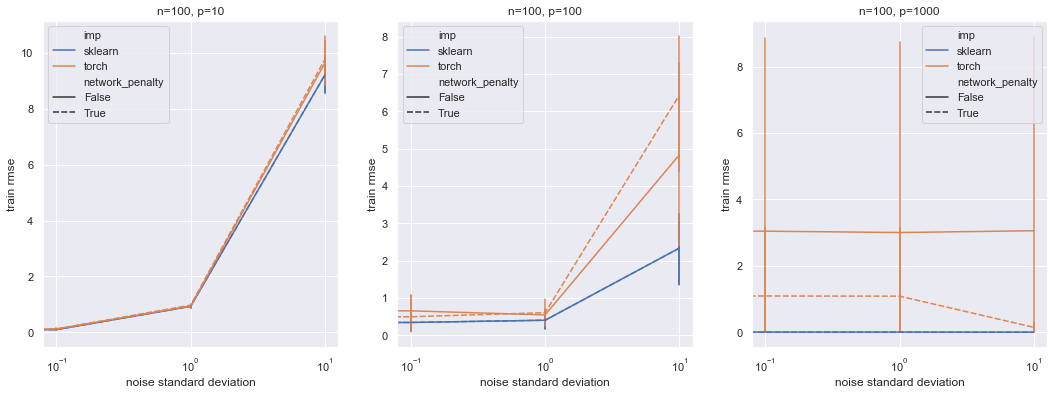

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
fig, axarr = plt.subplots(1, 3)
fig.set_figwidth(18)
fig.set_figheight(6)

metric = 'rmse'
for i, num_samples in enumerate([100]):
    for j, num_feats in enumerate((10, 100, 1000)):
        ax = axarr[j]
        filter_df = results_df[(results_df['num_samples'] == num_samples) &
                               (results_df['num_features'] == num_feats) &
                               (results_df['dataset'] == 'train') &
                               (results_df['uncorr_frac'] == p_uncorr_frac) &
                               (results_df['metric'] == metric)]
        filter_df = filter_df.sort_values(by='imp')
        sns.lineplot(data=filter_df, x='noise_stdev', y='value',
                     hue='imp', style='network_penalty', err_style='bars',
                     ax=ax)
        ax.set_title('n={}, p={}'.format(num_samples, num_feats))
        ax.set_xlabel('noise standard deviation')
        ax.set_xscale('log')
        ax.set_ylabel('train {}'.format(metric))
    

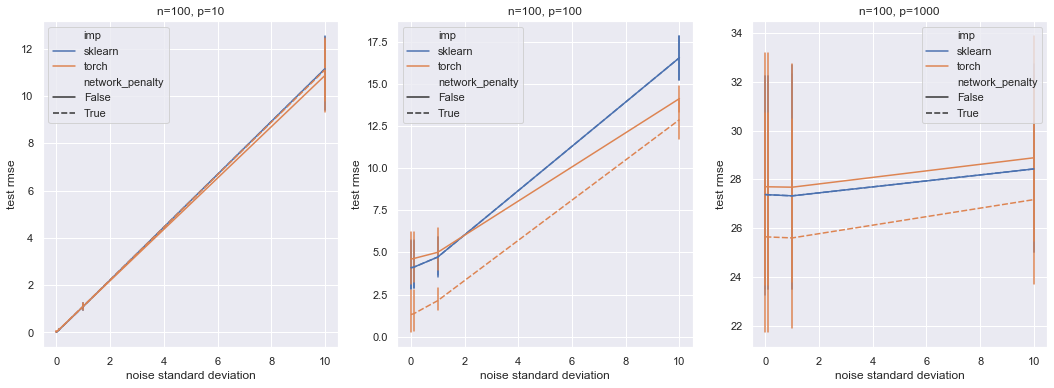

In [88]:
sns.set()
fig, axarr = plt.subplots(1, 3)
fig.set_figwidth(18)
fig.set_figheight(6)

metric = 'rmse'
for i, num_samples in enumerate([100]):
    for j, num_feats in enumerate((10, 100, 1000)):
        ax = axarr[j]
        filter_df = results_df[(results_df['num_samples'] == num_samples) &
                               (results_df['num_features'] == num_feats) &
                               (results_df['dataset'] == 'test') &
                               (results_df['uncorr_frac'] == p_uncorr_frac) &
                               (results_df['metric'] == metric)]
        filter_df = filter_df.sort_values(by='imp')
        sns.lineplot(data=filter_df, x='noise_stdev', y='value',
                     hue='imp', style='network_penalty', err_style='bars',
                     ax=ax)
        ax.set_title('n={}, p={}'.format(num_samples, num_feats))
        ax.set_xlabel('noise standard deviation')
        ax.set_ylabel('test {}'.format(metric))

So, it seems like the network-regularized model performs better when the number of features is roughly equal or greater to the number of samples. This seems to be fairly robust to the addition of noise (all the methods get worse with added noise, but the network-regularized model still performs better relatively speaking).

When there is enough data for the model to learn the correlation structure on its own (i.e. $n$ > $p$), the network penalty doesn't seem to help.

Now, let's look at how close the model coefficients are to the ones we used to generate the data. We're interested in these quantities:

* Network L2 penalty: $$\beta^{\top}L\beta$$ where $L$ is the graph Laplacian. This is what the model optimizes, so it had better be low for the network regularized model.
* Network L1 penalty: $$\sum_{m, l \in E} \sum_{\text{samples} j} |\hat{\beta}_{jm} - \hat{\beta}{jl}|$$ This isn't what the model optimizes but it's pretty close; should be fairly low for the network regularized model. (See http://doi.org/10.1371/journal.pgen.1000587 for mathy details)
* "True" coefficient loss: $$\sum_{i} |\beta_{i} - \hat{\beta}_{i}|$$ Absolute deviation of the estimated coefficients from the true coefficients used to simulate the data.

In [89]:
result_columns = ['imp', 'metric', 'value', 'num_samples', 
                  'num_features', 'noise_stdev', 'uncorr_frac', 'seed',
                  'network_penalty']
results_df = None

def compile_coefs(results_dir, n, p, noise_stdev, uncorr_frac, seed, network):
    true_coefs = []
    coefs_map = {}
    suffix = 'n{}_p{}_e{}_u{}_s{}.txt'.format(n, p, noise_stdev, uncorr_frac, seed)
    network_file = os.path.join(
        'sim_networks',
        'sim_groups_p{}_e{}_u{}_s{}.tsv'.format(p, noise_stdev, uncorr_frac, seed)
    )
    for fname in os.listdir(results_dir):
        if ('coefs' not in fname) or (suffix not in fname): continue
        imp = fname.split('_')[0]
        coefs = np.loadtxt(os.path.join(results_dir, fname), delimiter='\t',
                           ndmin=1)
        if imp == 'true':
            true_coefs = coefs
        else:
            coefs_map[imp] = coefs
    return calculate_metrics(network_file, true_coefs, coefs_map,
                             n, p, noise_stdev, uncorr_frac, seed,
                             network)

def calculate_metrics(network_file, true_coefs, coefs_map,
                      n, p, noise_stdev, uncorr_frac, seed,
                      network):
    import networkx as nx
    results = []
    # intercept is at the beginning of the list
    G = nx.read_weighted_edgelist(network_file, delimiter='\t')
    for imp, coefs in coefs_map.items():
        l2_loss = calculate_l2_loss(G, coefs)
        l1_loss = calculate_l1_loss(G, coefs)
        true_loss = calculate_true_loss(coefs, true_coefs)
        results.append([imp, 'l2_loss', l2_loss, n, p, noise_stdev,
                        uncorr_frac, seed, network])
        results.append([imp, 'l1_loss', l1_loss, n, p, noise_stdev,
                        uncorr_frac, seed, network])
        results.append([imp, 'true_loss', true_loss, n, p, noise_stdev,
                        uncorr_frac, seed, network])
    return pd.DataFrame(results, columns=result_columns)

def calculate_l2_loss(G, coefs):
    import networkx as nx
    L = nx.laplacian_matrix(G).toarray()
    assert coefs.shape[0]-1 == L.shape[0]
    return coefs[1:].T @ (L @ coefs[1:])

def calculate_l1_loss(G, coefs):
    return sum([abs(coefs[int(i)] - coefs[int(j)]) for (i, j) in G.edges if i != j])

def calculate_true_loss(coefs, true_coefs):
    # truncate in case where some of the coefs are uncorrelated with outcome
    t_coefs = coefs[:true_coefs.shape[0]]
    return sum([abs(t_coefs[i] - true_coefs[i]) for i in range(t_coefs.shape[0])])

# read results from output directory
for fname in os.listdir(results_dir):
    if os.path.isdir(fname): continue
    if 'true_coefs' not in fname: continue
    f_sp = os.path.splitext(fname)[0].split('_')
    n = int(f_sp[2].replace('n', ''))
    p = int(f_sp[3].replace('p', ''))
    noise_stdev = float(f_sp[4].replace('e', ''))
    uncorr_frac = float(f_sp[5].replace('u', ''))
    seed = int(f_sp[6].replace('s', ''))
    df = compile_coefs(results_dir, n, p, noise_stdev,
                       uncorr_frac, seed, network=True)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.concat((results_df, df))
        
# read results from output directory
for fname in os.listdir(results_dir_nn):
    if os.path.isdir(fname): continue
    if 'true_coefs' not in fname: continue
    f_sp = os.path.splitext(fname)[0].split('_')
    n = int(f_sp[2].replace('n', ''))
    p = int(f_sp[3].replace('p', ''))
    noise_stdev = float(f_sp[4].replace('e', ''))
    uncorr_frac = float(f_sp[5].replace('u', ''))
    seed = int(f_sp[6].replace('s', ''))
    df = compile_coefs(results_dir_nn, n, p, noise_stdev,
                       uncorr_frac, seed, network=False)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.concat((results_df, df))
    
results_df.head(n=10)

,imp,metric,value,num_samples,num_features,noise_stdev,uncorr_frac,seed,network_penalty
0,torch,l2_loss,0.002304,100,100,0.0,0.50,1,True
1,torch,l1_loss,16.159870,100,100,0.0,0.50,1,True
2,torch,true_loss,4.707080,100,100,0.0,0.50,1,True
3,sklearn,l2_loss,2.663299,100,100,0.0,0.50,1,True
4,sklearn,l1_loss,16.381700,100,100,0.0,0.50,1,True
5,sklearn,true_loss,10.496160,100,100,0.0,0.50,1,True
0,torch,l2_loss,0.002328,500,1000,1.0,0.25,2,True
1,torch,l1_loss,503.106380,500,1000,1.0,0.25,2,True
2,torch,true_loss,190.704510,500,1000,1.0,0.25,2,True
3,sklearn,l2_loss,372.733535,500,1000,1.0,0.25,2,True


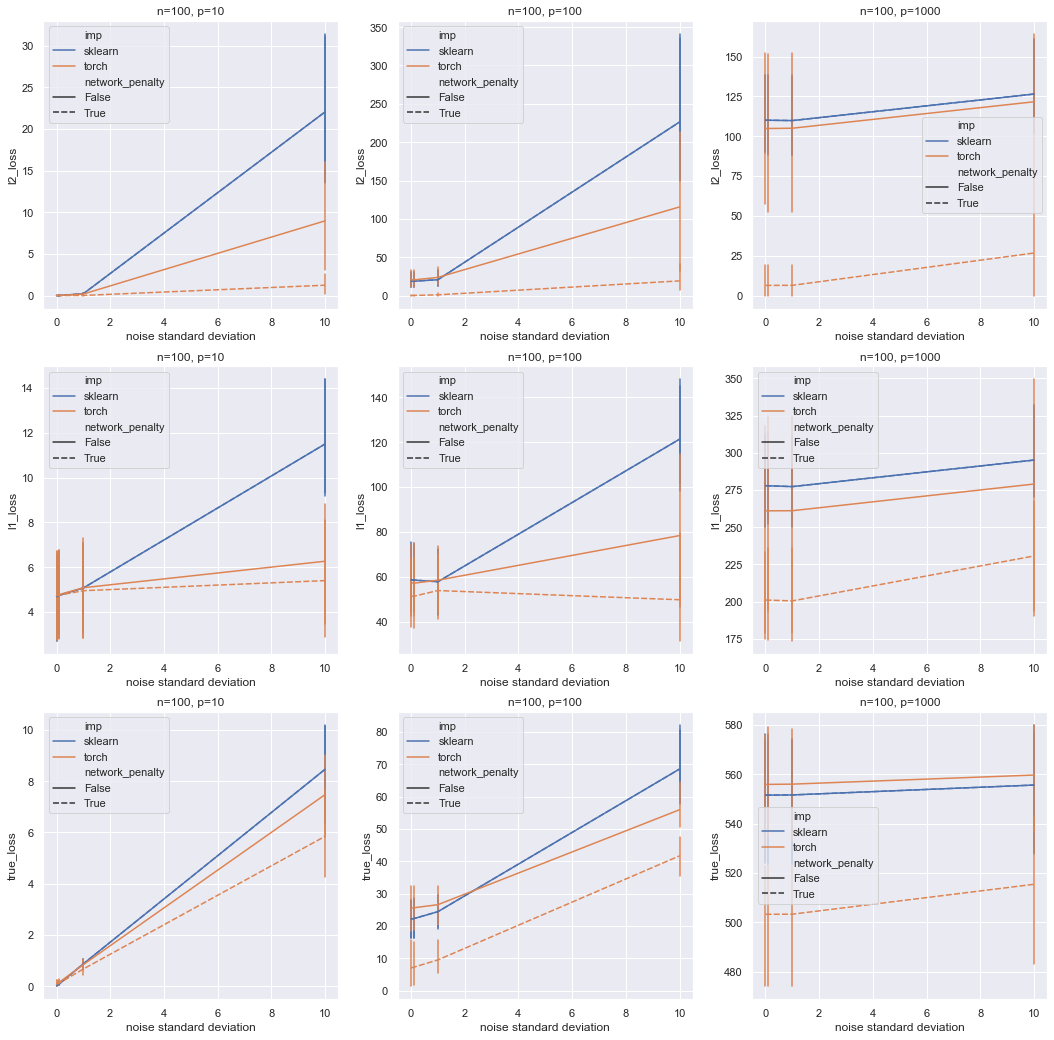

In [90]:
sns.set()
fig, axarr = plt.subplots(3, 3)
fig.set_figwidth(18)
fig.set_figheight(18)

num_samples = 100
for i, metric in enumerate(('l2_loss', 'l1_loss', 'true_loss')):
    for j, num_feats in enumerate((10, 100, 1000)):
        ax = axarr[i, j]
        filter_df = results_df[(results_df['num_samples'] == num_samples) &
                               (results_df['num_features'] == num_feats) &
                               (results_df['uncorr_frac'] == p_uncorr_frac) &
                               (results_df['metric'] == metric)]
        filter_df = filter_df.sort_values(by='imp')
        sns.lineplot(data=filter_df, x='noise_stdev', y='value',
                     hue='imp', style='network_penalty', err_style='bars',
                     ax=ax)
        ax.set_title('n={}, p={}'.format(num_samples, num_feats))
        ax.set_xlabel('noise standard deviation')
        ax.set_ylabel('{}'.format(metric))
    

So, the network regularized model does a fairly good job of optimizing all 3 of these criteria. That means the model is working (at least on this simple simulated benchmark)!